# __Bagging y Random Forest__

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import lec8_graphs as afx
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)


## Bootstrapping

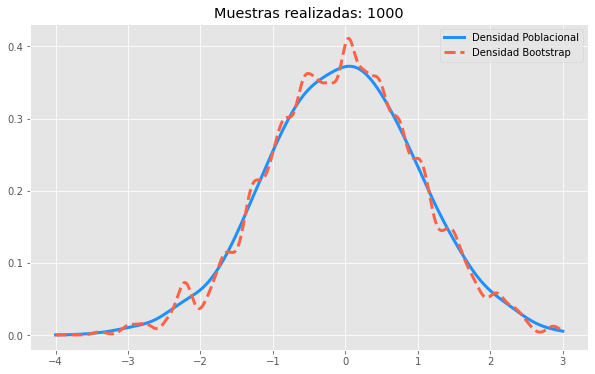

In [2]:
afx.plot_bootstrap(n_sims=1000)

## Implementación Bagging

In [3]:
import pandas as pd
# Importar base
df = pd.read_csv('cadata.csv', header=1).drop(columns='1')


In [4]:
# Cambiar escala a logarítmica
df['log_MedianIncome'] = np.log(df['MedianIncome'])
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
df = df.drop(columns=['MedianHouseValue', 'MedianIncome'])


In [5]:
from sklearn.model_selection import train_test_split
# Dividir muestra
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'MedianHouseAge':'log_MedianIncome'], df['log_MedianHouseValue'], test_size=.33, random_state=11238)

In [6]:
from sklearn.ensemble import BaggingRegressor
# Crear modelo de bagging
bagging_model = BaggingRegressor(random_state=11238).fit(X_train, y_train)

In [ ]:
# Revisar modelos estimados
for i in bagging_model.estimators_:
    print("Modelo: {}. Criterio: {}. Semilla: {}".format(type(i), i.criterion,i.random_state))


In [7]:
# Revisar métricas
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
print("MSE:", mean_squared_error(y_test, bagging_model.predict(X_test)))
print("MAE:", median_absolute_error(y_test, bagging_model.predict(X_test)))
print("R2:", r2_score(y_test, bagging_model.predict(X_test)))


MSE: 0.060855820142651694
MAE: 0.12377597769605853
R2: 0.8151703385308645


### Análisis de Predicciones

In [9]:
hold_instance = [i.predict(X_test[:1]) for i in bagging_model.estimators_]
dec_tree_lab = ["RegressionTree: {}".format(i + 1) for i in range(len(bagging_model.estimators_))]


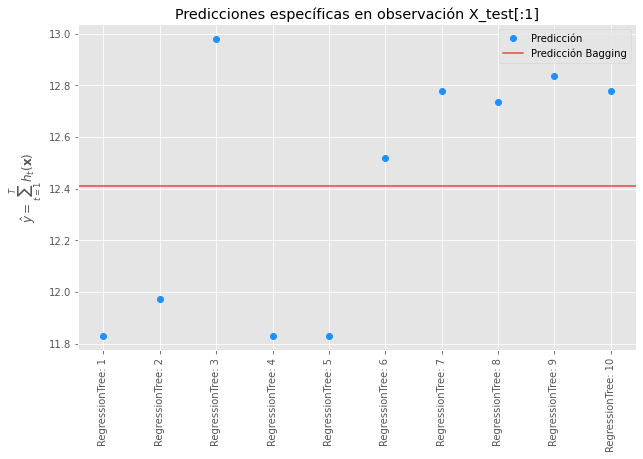

In [10]:
plt.plot(hold_instance, 'o', color='dodgerblue', label='Predicción')
plt.xticks(range(10), dec_tree_lab,rotation =90)
plt.axhline(bagging_model.predict(X_test[:1]), label='Predicción Bagging')
plt.ylabel(r'$\hat{y} = \sum_{t=1}^{T} h_{t}(\mathbf{x})$')
plt.title('Predicciones específicas en observación X_test[:1]')
plt.legend();

## Efecto de la cantidad de modelos incorporados en el ensamble

In [11]:
# generamos 3 listas para guardar resultados
tmp_mse_test, tmp_mae_test, tmp_r2_test = [], [], []
# generamos valores a pasar
n_tree = range(20, 1000, 50)
# Para cada uno de los rangos declarados
for i in n_tree:
    # Entrenamos nuestro modelo
    tmp_bag_model = BaggingRegressor(n_estimators=i, random_state=11238).fit(X_train,y_train)
    # guardamos el mse
    tmp_mse_test.append(mean_squared_error(y_test,     tmp_bag_model.predict(X_test)))
    # guardamos el mae
    tmp_mae_test.append(median_absolute_error(y_test,     tmp_bag_model.predict(X_test)))
    # guardamos el rcuadrado
    tmp_r2_test.append(r2_score(y_test, tmp_bag_model.predict(X_test)))

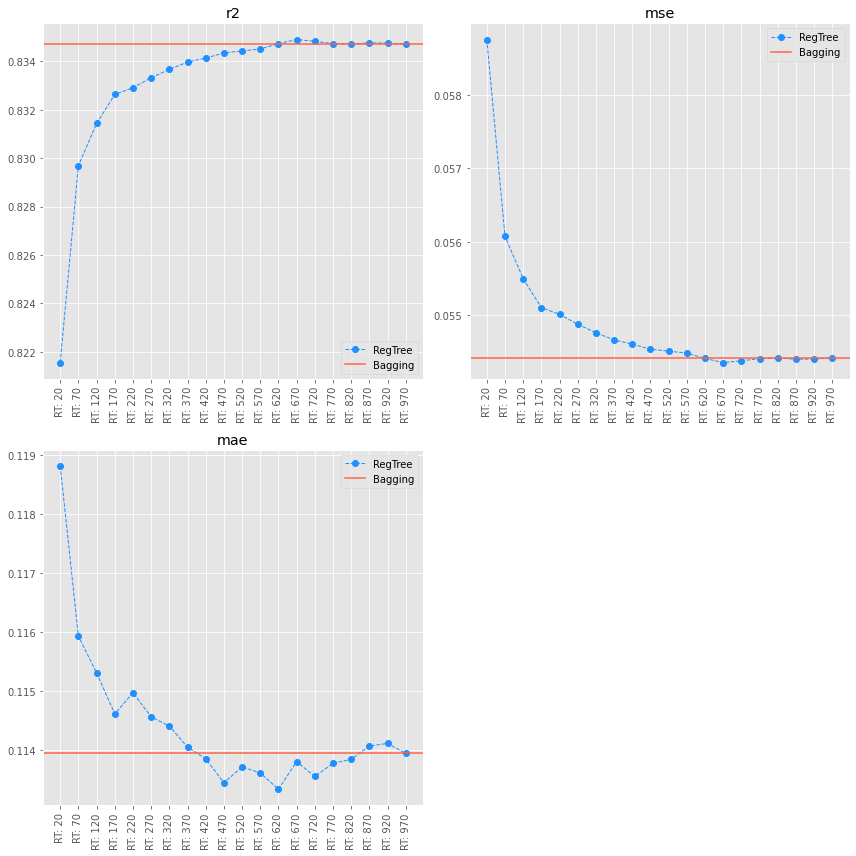

In [12]:
params = [
    [1, tmp_r2_test, r2_score(y_test, tmp_bag_model.predict(X_test)), 'r2'],
    [2, tmp_mse_test, mean_squared_error(y_test, tmp_bag_model.predict(X_test)), 'mse'],
    [3, tmp_mae_test, median_absolute_error(y_test, tmp_bag_model.predict(X_test)), 'mae']
]
plt.figure(figsize=(12, 12))
for i in params:
    plt.subplot(2, 2, i[0])
    afx.plot_bagging_behavior(i[1], i[2], n_tree)
    plt.title(str(i[3]))
plt.tight_layout()

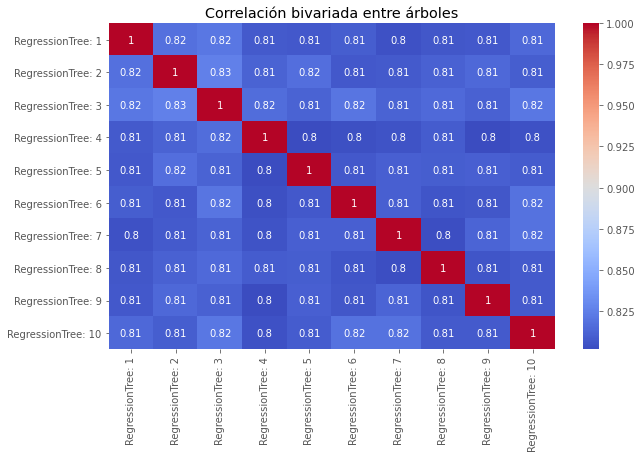

In [13]:
from scipy import stats
import seaborn as sns
store_rho = []
"""
Guardamos los estimadores de nuestro
primer modelo.
"""
bag_est = bagging_model.estimators_
# recorremos dos veces los estimadores
for i in bag_est:
    for j in bag_est:
        # y calculamos las correlaciones entre pares
        store_rho.append(stats.pearsonr(i.predict(X_test), j.predict(X_test))[0])
store_rho = np.array(store_rho).reshape(len(bag_est), len(bag_est))
sns.heatmap(store_rho, cmap='coolwarm', annot=True, xticklabels=dec_tree_lab, yticklabels=dec_tree_lab);
plt.title("Correlación bivariada entre árboles");

## Implementación Random Forest

In [16]:
df = pd.read_csv('voting.csv').drop(columns='Unnamed: 0')
# Vamos a binarizar cada variable categórica, ignorando la primera categoría de referencia
# Región del país
df = pd.concat([df, pd.get_dummies(df['region'], drop_first=True, prefix='region')], axis=1)
# Nivel educacional del encuestado
df = pd.concat([df, pd.get_dummies(df['education'], drop_first=True, prefix='ed')], axis=1)
# Sexo del encuestado
df = pd.concat([df, pd.get_dummies(df['sex'], drop_first=True, prefix='sex')], axis=1)
# Intención de voto
df = pd.concat([df, pd.get_dummies(df['vote'], drop_first=False, prefix='vote')], axis=1)
# Botamos las variables originales
df = df.drop(columns=['region', 'sex', 'education', 'vote'])
df.head()
# Nos aseguramos de limpiar los datos perdidos
df = df.dropna()
# generamos las muestras definiendo la matriz de atributos
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'population':'ed_S'], df['vote_N'], test_size=.33, random_state=11238)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


In [20]:
voting_rf = RandomForestClassifier(oob_score=True, random_state=11238).fit(X_train, y_train)
print(classification_report(y_test, voting_rf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.85      0.88      0.86       572
           1       0.73      0.68      0.71       283

    accuracy                           0.81       855
   macro avg       0.79      0.78      0.78       855
weighted avg       0.81      0.81      0.81       855



In [22]:
voting_rf.feature_importances_

array([0.05138179, 0.15510618, 0.06755217, 0.6432028 , 0.00546114,
       0.0106552 , 0.01352727, 0.01456509, 0.02142398, 0.01712438])

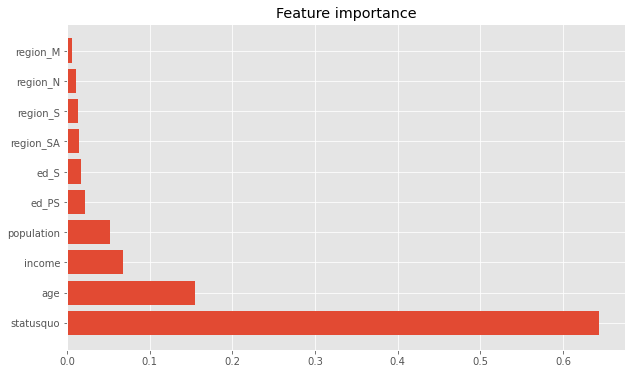

In [24]:
import lec8_graphs as afx
afx.plot_importance(voting_rf, X_train.columns)

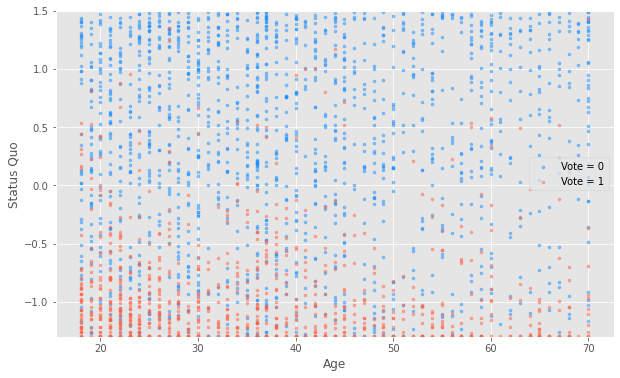

In [25]:
depured_X = df.loc[:, ['age', 'statusquo', 'vote_N']]
colors = ['dodgerblue', 'tomato']
for i in depured_X['vote_N'].unique():
    plt.scatter(
        depured_X[depured_X['vote_N'] == i]['age'],
        depured_X[depured_X['vote_N'] == i]['statusquo'],
        marker='.',
        label="Vote = {}".format(i), alpha=.5, color=colors[i])
plt.legend();
plt.ylim(-1.3, 1.5);
plt.ylabel('Status Quo');
plt.xlabel('Age');

In [26]:
random_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=11238,oob_score=True)
random_forest.fit(depured_X.loc[:, 'age':'statusquo'], depured_X['vote_N'])
get_x_1 = afx.fetch_lims(depured_X['statusquo'])
get_x_2 = afx.fetch_lims(depured_X['age'])
x_mesh, y_mesh, joint_xy = afx.generate_mesh_grid(depured_X, 'age', 'statusquo')
Z = random_forest.predict_proba(np.c_[x_mesh.ravel(), y_mesh.ravel()])[:, 1].reshape(x_mesh.shape)

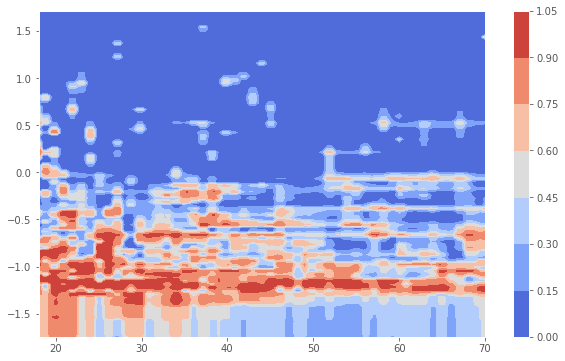

In [27]:
plt.contourf(x_mesh, y_mesh, Z, cmap='coolwarm')
plt.colorbar();

In [29]:
# generamos una serie de listas para guardar los valores
tmp_oob_none, tmp_oob_sqrt,tmp_oob_log2 = [], [], []
tmp_test_acc_none, tmp_test_acc_sqrt, tmp_test_acc_log = [], [], []
n_estimators = range(20, 1000, 25)

In [30]:
# para cada rango de modelos estimados
for i in n_estimators:
    # Implementamos una variante con todos los atributos
    voting_rf_none = RandomForestClassifier(
        n_estimators=i,
        max_features=None,
        oob_score=True,
        random_state=123
    ).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con sqrt
    voting_rf_sqrt = RandomForestClassifier(
        n_estimators= i,
        max_features="sqrt",
        warm_start=True,
        oob_score=True,
        random_state=123
    ).fit(X_train, y_train)
    # Implementamos una variante donde los atributos se escogen con log
    voting_rf_log = RandomForestClassifier(
        n_estimators= i,
        max_features="log2",
        warm_start=True,
        oob_score=True,
        random_state=123
    ).fit(X_train, y_train)
    # Estimamos el error en OOB
    tmp_oob_none.append(1 - voting_rf_none.oob_score_)
    tmp_oob_sqrt.append(1 - voting_rf_sqrt.oob_score_)
    tmp_oob_log2.append(1 - voting_rf_log.oob_score_)
    # Estimamos el error en la exactitud
    tmp_test_acc_none.append(1 - accuracy_score(y_test, voting_rf_none.predict(X_test)))
    tmp_test_acc_sqrt.append(1 - accuracy_score(y_test, voting_rf_sqrt.predict(X_test)))
    tmp_test_acc_log.append(1 - accuracy_score(y_test, voting_rf_log.predict(X_test)))

<Figure size 864x288 with 0 Axes>

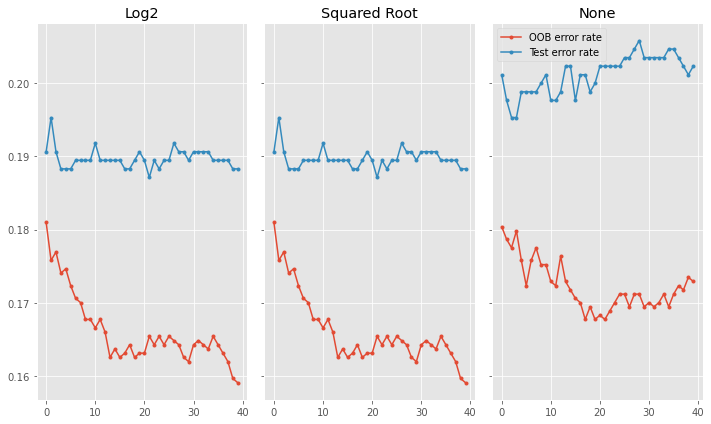

In [31]:
plt.figure(figsize=(12, 4))
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].plot(tmp_oob_log2, '.-', label='OOB error rate')
axs[0].plot(tmp_test_acc_log, '.-', label='Test error rate')
axs[0].set_title('Log2')
axs[1].plot(tmp_oob_sqrt,'.-', label='OOB error rate')
axs[1].plot(tmp_test_acc_sqrt,'.-', label='Test error rate')
axs[1].set_title('Squared Root')
axs[2].plot(tmp_oob_none, '.-', label='OOB error rate')
axs[2].plot(tmp_test_acc_none,'.-', label='Test error rate')
axs[2].set_title('None')
plt.tight_layout()
plt.legend();
